In [1]:
import torch
import h5py
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
import torch.nn.functional as func


from torch.optim import lr_scheduler
import time
import copy
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
import torch.nn.functional as F

from utils.loss import dice_loss, calc_loss, print_metrics
from tqdm.notebook import tqdm
from utils.common import get_model



In [2]:
def multiclass_to_binary(mask, class_num=3):
    device = mask.device
    new_mask = torch.zeros((class_num, mask.shape[-2], mask.shape[-1]))
    new_mask = new_mask.to(device)
    for i in range(class_num):
        new_mask[i,:,:] = torch.where(mask==i+1, 1, 0)
    return new_mask

In [3]:
class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path, device):
        super().__init__()
        self.device = device
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        binary_mask = multiclass_to_binary(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return img, binary_mask
#     dict(
#             c=c, 
#             mask=mask.to(self.device),
#             binary_mask = binary_mask.to(self.device),
#             img=img.to(self.device), 
#             mean=mean[None, None, None].to(self.device), 
#             std=std[None, None, None].to(self.device)
#         )

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_set = ACDCDataset('/home/e_radionova/Datasets/ACDC/train.h5', device)
val_set = ACDCDataset('/home/e_radionova/Datasets/ACDC/val.h5', device)

In [5]:
image_datasets = {
    'train': train_set , 'val': val_set
}

batch_size_train = 8
batch_size_val = batch_size_train

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 1188, 'val': 514}

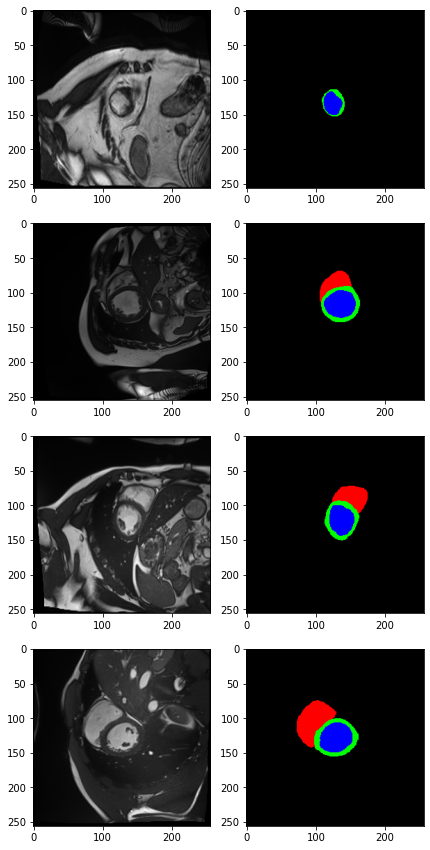

In [6]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

n_pics_to_show = 4
inputs, masks = next(iter(dataloaders['train']))
fig, ax = plt.subplots(n_pics_to_show, 2, figsize=(7, 15))
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i]
#     print(np.unique(label))
    label_np = label.data.numpy().transpose(1, 2, 0)
    pic_np = pic.data.numpy()[0]#.transpose(1, 2, 0) 
    ax[i,0].imshow(pic_np, cmap='gray')
    ax[i,1].imshow(label_np, cmap='gray')

In [7]:
# unet
# attention-unet
# lorck
# def-convs
# unet_init
model_name = 'hybrid'

In [8]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

k_size = 7
kk2_size=7
model = get_model(model_name, in_chs=1, out_chs=3, k_size=k_size, kk2_size=kk2_size)
model = model.to(device)

In [9]:
file_name = f'{model_name}_acdc_b{batch_size_train}_with_k_size_{k_size}__{kk2_size}'

In [10]:
optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

exp_name = f'{file_name}_' + datetime.now().isoformat(timespec='minutes') 

In [11]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_with_logits

In [12]:
def train_model(model, dataloaders, optimizer, scheduler, 
                experiment_name, device,
                tensorboard=True, logs_base_dir='logs', 
                save_weights=False, weights_path='weights/model',
                save_metrics=False, metrics_path='metrics_txt/model',
                add_loss_to_kernel=False,
                num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    best_dice = 0
    best_dice_0 = 0
    best_dice_1 = 0
    best_dice_2 = 0
    
    logs_base_dir = Path(logs_base_dir)
    logs_base_dir.mkdir(exist_ok=True)
    if tensorboard:
        writer = SummaryWriter(logs_base_dir / experiment_name)

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()
        i=0
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train': 
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)    

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if not add_loss_to_kernel:                       
                        loss = calc_loss(outputs, labels, metrics)
                    else:
                        loss_kernel = 0
                        try:
                            kernel = model.dconv_down1[0].weight.data
                        except:
                            kernel = model.Conv_upd_x1.conv[0].weight.data
                        ups = nn.Upsample(size=kernel.shape[-1])
                        l_kernel = ups(labels)
                        l_kernel = (l_kernel - l_kernel.mean()) / l_kernel.std()                        
                        
                        if l_kernel.shape[1] != kernel.shape[1]:
#                             labels_kernel = torch.cat((l_kernel,l_kernel,l_kernel), 1)
                            labels_kernel = l_kernel
                        else:
                            labels_kernel = l_kernel
                        bs = labels.shape[0]
                        for i in range(0, kernel.shape[0]-bs+1, bs):
                            loss_kernel += bce_with_logits(kernel[i:i+labels_kernel.shape[0]], 
                                                           labels_kernel[:,2].unsqueeze(1))
                        loss_target = calc_loss(outputs, labels, metrics)
                        metrics['loss_kernel'] += loss_kernel.data.cpu().numpy() * labels.size(0)
                        loss = loss_target + loss_kernel                                

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                epoch_samples += inputs.size(0)
                

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples 
#             epoch_loss_kernel = metrics['loss_kernel'] / epoch_samples
            dice_epoch = metrics['dice'] / epoch_samples
            dice_epoch_0 = metrics['dice_0'] / epoch_samples
            dice_epoch_1 = metrics['dice_1'] / epoch_samples
            dice_epoch_2 = metrics['dice_2'] / epoch_samples
            
            if tensorboard:
                writer.add_scalar(f'Loss_{phase}', epoch_loss.item(), global_step=epoch)
#                 writer.add_scalar(f'Loss_kernel{phase}', epoch_loss_kernel.item(), global_step=epoch)
                writer.add_scalar(f'DICE_{phase}', dice_epoch.item(), global_step=epoch)
                writer.add_scalar(f'DICE_0_{phase}', dice_epoch_0.item(), global_step=epoch)
                writer.add_scalar(f'DICE_1_{phase}', dice_epoch_1.item(), global_step=epoch)
                writer.add_scalar(f'DICE_2_{phase}', dice_epoch_2.item(), global_step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best loss")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_weights:
                    Path(weights_path.split('/')[-3] + '/' + weights_path.split('/')[-2]).mkdir(exist_ok=True)
                    torch.save(model.state_dict(), f'{weights_path}.pth')
            
            if phase == 'val' and dice_epoch > best_dice:
#                 print("saving best DICE")
                best_dice = dice_epoch
            if phase == 'val' and dice_epoch_0 > best_dice_0:
#                 print("saving best DICE")
                best_dice_0 = dice_epoch_0
            if phase == 'val' and dice_epoch_1 > best_dice_1:
#                 print("saving best DICE")
                best_dice_1 = dice_epoch_1
            if phase == 'val' and dice_epoch_2 > best_dice_2:
#                 print("saving best DICE")
                best_dice_2 = dice_epoch_2
                
            print('epoch', epoch)
            show_kernel(model)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val DICE: {:4f}'.format(best_dice))
    
    if save_metrics:
        Path(metrics_path.split('/')[-3] + '/' + metrics_path.split('/')[-2]).mkdir(exist_ok=True)
        with open(f"{metrics_path}.txt","a") as the_file:
                the_file.write('best DICE: {}\n'.format(best_dice))
                the_file.write('best DICE_0: {}\n'.format(best_dice_0))
                the_file.write('best DICE_1: {}\n'.format(best_dice_1))
                the_file.write('best DICE_2: {}\n'.format(best_dice_2))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

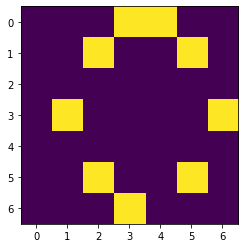

In [13]:
# ### INIT
dataset_path = '/home/e_radionova/Datasets/ACDC/train.h5'
train_masks_path = h5py.File(dataset_path)
mask_kernel = np.where(train_masks_path['3'][1]==2, 1, 0)[90:170, 90:170]
# plt.imshow(mask_kernel)
# plt.show()
mask_kernel = mask_kernel.astype(np.uint8)
# plt.imshow(mask_kernel)

import albumentations as A
ab = A.Compose([
    A.Resize(k_size, k_size)
])
transformed = ab(image=mask_kernel, mask=mask_kernel)
res = transformed["mask"]
res = (res - res.mean()) / res.std()
plt.imshow(res)

In [14]:
# shape_k = model.dconv_down1[0].weight.data.shape
# # shape_k = model.Conv_upd_x1.conv[0].weight.data.shape
# kernel = torch.zeros_like(torch.rand(shape_k))
# kernel_new = torch.from_numpy(res)
# for i in range(kernel.shape[0]):
#     kernel[i] = kernel_new
# model.dconv_down1[0].weight.data = torch.tensor(kernel, requires_grad=True)
# model.dconv_down1[0].weight.data = model.dconv_down1[0].weight.data.to(device)

In [15]:
shape_k = model.Conv1.conv[0].weight.data.shape
# shape_k = model.Conv_upd_x1.conv[0].weight.data.shape
kernel = torch.zeros_like(torch.rand(shape_k))
kernel_new = torch.from_numpy(res)
for i in range(kernel.shape[0]):
    kernel[i] = kernel_new
model.Conv1.conv[0].weight.data = torch.tensor(kernel, requires_grad=True)
model.Conv1.conv[0].weight.data = model.Conv1.conv[0].weight.data.to(device)

/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [16]:
# def show_kernel(model):
#     print(model.dconv_down1[0].weight.data[:1,:1,:1,:10])
#     fig, ax = plt.subplots(2, 5, figsize=(10, 5))
#     for i in range(10):
#         ax[i//5,i%5].imshow(model.dconv_down1[0].weight.data[i].cpu().permute(1,2,0), cmap='gray')
#     plt.show()
    
def show_kernel(model):
    print(model.Conv1.conv[0].weight.data[:1,:1,:1,:10])
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    for i in range(10):
        ax[i//5,i%5].imshow(model.Conv1.conv[0].weight.data[i].cpu().permute(1,2,0), cmap='gray')
    plt.show()

In [17]:
# model.dconv_down1[0].weight.data.shape
model.Conv1.conv[0].weight.data.shape

torch.Size([64, 1, 7, 7])

In [18]:
model.Conv_upd_x1.conv[0].weight.data.shape

torch.Size([64, 1, 7, 7])

In [19]:
from pathlib import Path

2022-03-20 13:28:33.820088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/cv2/../../lib64:
2022-03-20 13:28:33.820115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49
----------
LR 0.001


/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/149 [00:00<?, ?it/s]

/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: dice_0: 0.050302, dice_1: 0.091813, dice_2: 0.111835, dice: 0.084650, loss: 0.560027
epoch 0
tensor([[[[-0.4434, -0.4481, -0.4502,  2.1260,  2.1209, -0.4641, -0.4672]]]],
       device='cuda:0')


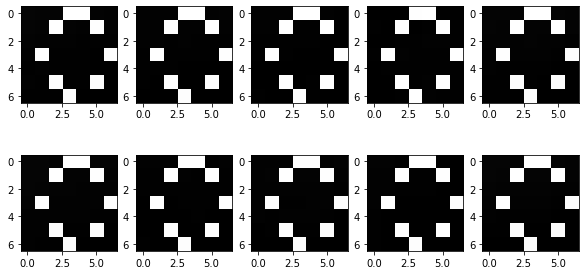

  0%|          | 0/65 [00:00<?, ?it/s]

val: dice_0: 0.096606, dice_1: 0.183573, dice_2: 0.215505, dice: 0.165228, loss: 0.496463
saving best loss
epoch 0
tensor([[[[-0.4434, -0.4481, -0.4502,  2.1260,  2.1209, -0.4641, -0.4672]]]],
       device='cuda:0')


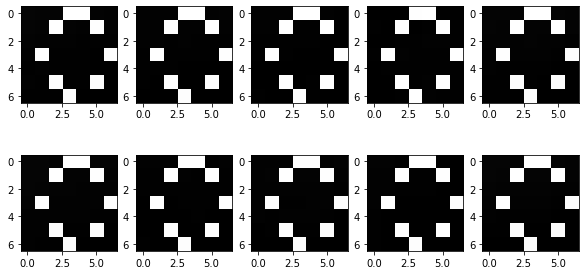

1m 16s
Epoch 1/49
----------
LR 0.001


  0%|          | 0/149 [00:00<?, ?it/s]

train: dice_0: 0.354950, dice_1: 0.520764, dice_2: 0.593415, dice: 0.489710, loss: 0.270796
epoch 1
tensor([[[[-0.4176, -0.4265, -0.4326,  2.1414,  2.1330, -0.4581, -0.4634]]]],
       device='cuda:0')


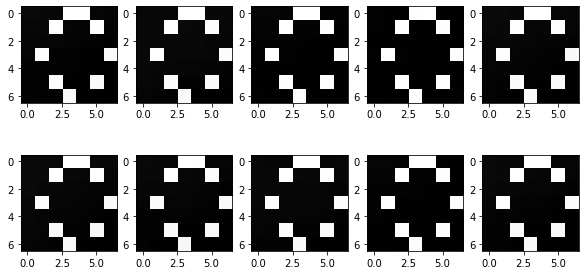

  0%|          | 0/65 [00:00<?, ?it/s]

val: dice_0: 0.537842, dice_1: 0.596662, dice_2: 0.651739, dice: 0.595415, loss: 0.218024
saving best loss
epoch 1
tensor([[[[-0.4176, -0.4265, -0.4326,  2.1414,  2.1330, -0.4581, -0.4634]]]],
       device='cuda:0')


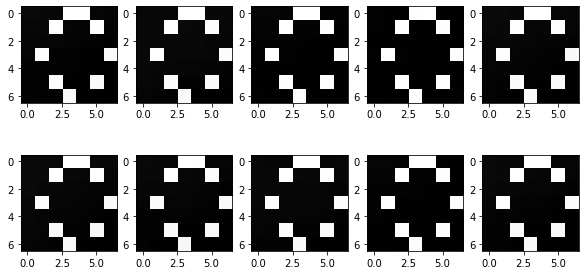

1m 49s
Epoch 2/49
----------
LR 0.001


  0%|          | 0/149 [00:00<?, ?it/s]

train: dice_0: 0.547711, dice_1: 0.681696, dice_2: 0.772974, dice: 0.667460, loss: 0.176716
epoch 2
tensor([[[[-0.4062, -0.4181, -0.4235,  2.1509,  2.1381, -0.4601, -0.4676]]]],
       device='cuda:0')


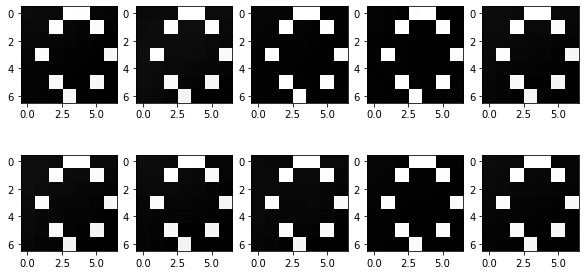

  0%|          | 0/65 [00:00<?, ?it/s]

val: dice_0: 0.594026, dice_1: 0.705346, dice_2: 0.805636, dice: 0.701669, loss: 0.160085
saving best loss
epoch 2
tensor([[[[-0.4062, -0.4181, -0.4235,  2.1509,  2.1381, -0.4601, -0.4676]]]],
       device='cuda:0')


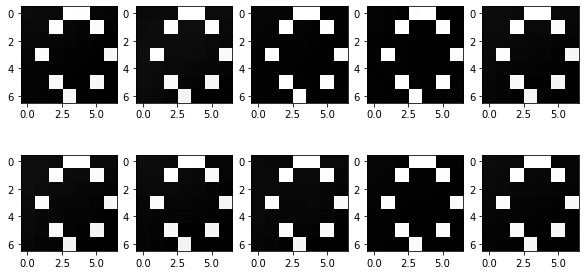

1m 48s
Epoch 3/49
----------
LR 0.001


  0%|          | 0/149 [00:00<?, ?it/s]

train: dice_0: 0.606630, dice_1: 0.711753, dice_2: 0.803359, dice: 0.707247, loss: 0.155620
epoch 3
tensor([[[[-0.3964, -0.4098, -0.4132,  2.1617,  2.1463, -0.4566, -0.4662]]]],
       device='cuda:0')


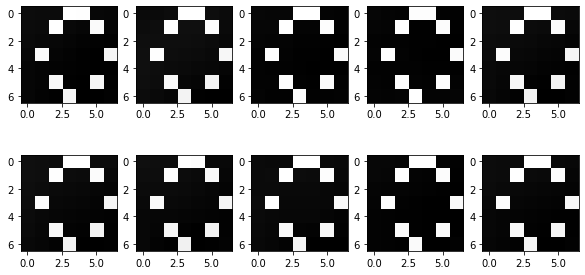

  0%|          | 0/65 [00:00<?, ?it/s]

val: dice_0: 0.657094, dice_1: 0.750026, dice_2: 0.849926, dice: 0.752349, loss: 0.131822
saving best loss
epoch 3
tensor([[[[-0.3964, -0.4098, -0.4132,  2.1617,  2.1463, -0.4566, -0.4662]]]],
       device='cuda:0')


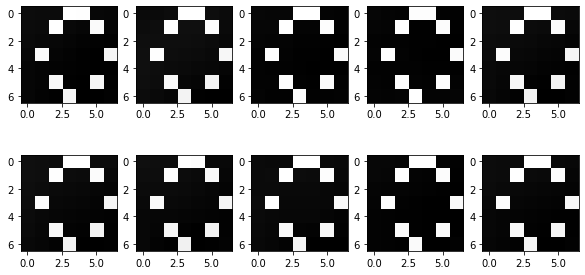

1m 30s
Epoch 4/49
----------
LR 0.001


  0%|          | 0/149 [00:00<?, ?it/s]

train: dice_0: 0.649400, dice_1: 0.751494, dice_2: 0.836948, dice: 0.745947, loss: 0.135045
epoch 4
tensor([[[[-0.3913, -0.4039, -0.4051,  2.1691,  2.1504, -0.4560, -0.4667]]]],
       device='cuda:0')


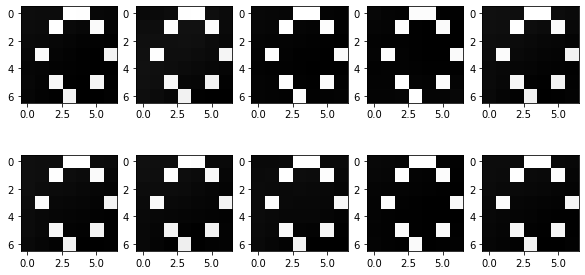

  0%|          | 0/65 [00:00<?, ?it/s]

val: dice_0: 0.674699, dice_1: 0.717528, dice_2: 0.803746, dice: 0.731991, loss: 0.143621
epoch 4
tensor([[[[-0.3913, -0.4039, -0.4051,  2.1691,  2.1504, -0.4560, -0.4667]]]],
       device='cuda:0')


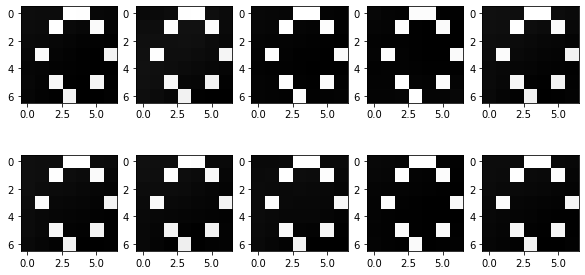

1m 59s
Epoch 5/49
----------
LR 0.001


  0%|          | 0/149 [00:00<?, ?it/s]

train: dice_0: 0.668407, dice_1: 0.757010, dice_2: 0.845930, dice: 0.757116, loss: 0.129704
epoch 5
tensor([[[[-0.3831, -0.3990, -0.3995,  2.1759,  2.1538, -0.4552, -0.4646]]]],
       device='cuda:0')


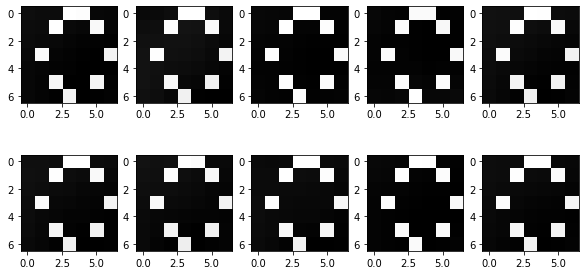

  0%|          | 0/65 [00:00<?, ?it/s]

val: dice_0: 0.673289, dice_1: 0.671969, dice_2: 0.835097, dice: 0.726785, loss: 0.148975
epoch 5
tensor([[[[-0.3831, -0.3990, -0.3995,  2.1759,  2.1538, -0.4552, -0.4646]]]],
       device='cuda:0')


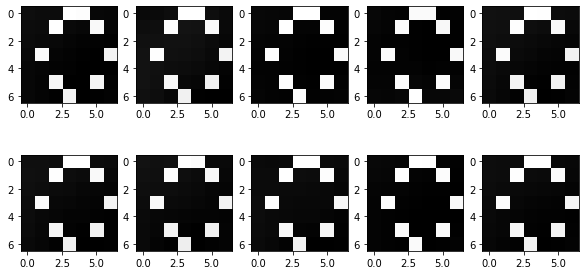

1m 33s
Epoch 6/49
----------
LR 0.001


  0%|          | 0/149 [00:00<?, ?it/s]

train: dice_0: 0.677551, dice_1: 0.752974, dice_2: 0.842822, dice: 0.757782, loss: 0.130085
epoch 6
tensor([[[[-0.3746, -0.3896, -0.3887,  2.1849,  2.1584, -0.4553, -0.4669]]]],
       device='cuda:0')


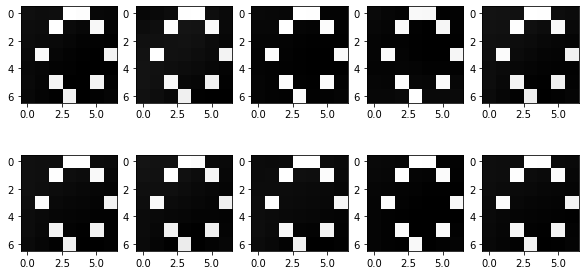

  0%|          | 0/65 [00:00<?, ?it/s]

val: dice_0: 0.708261, dice_1: 0.744621, dice_2: 0.826526, dice: 0.759802, loss: 0.130978
saving best loss
epoch 6
tensor([[[[-0.3746, -0.3896, -0.3887,  2.1849,  2.1584, -0.4553, -0.4669]]]],
       device='cuda:0')


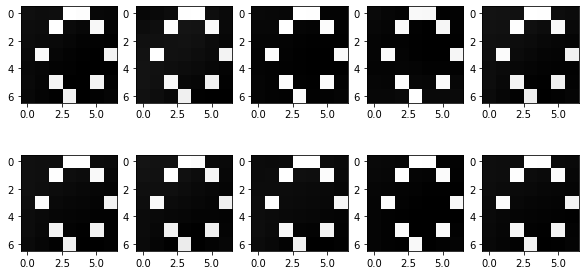

1m 48s
Epoch 7/49
----------
LR 0.001


  0%|          | 0/149 [00:00<?, ?it/s]

train: dice_0: 0.697726, dice_1: 0.756186, dice_2: 0.845119, dice: 0.766344, loss: 0.127474
epoch 7
tensor([[[[-0.3729, -0.3902, -0.3881,  2.1839,  2.1548, -0.4597, -0.4699]]]],
       device='cuda:0')


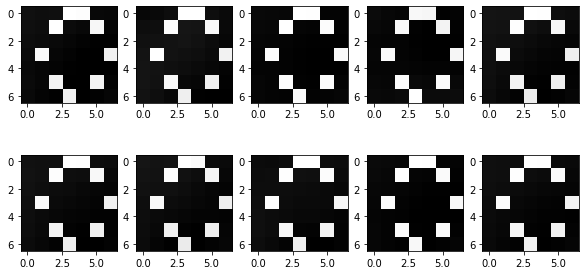

  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
model = train_model(model=model, dataloaders=dataloaders, 
                    optimizer=optimizer_ft, scheduler=exp_lr_scheduler, 
                    experiment_name=exp_name, device=device,
                    tensorboard=True, logs_base_dir='./logs/logs_acdc', 
                    save_weights=True, weights_path=f'./weights/acdc/{exp_name}',
                    save_metrics=True, metrics_path=f'./metrics_txt/acdc/{file_name}',
                    add_loss_to_kernel=False,
                    num_epochs=50)

In [ ]:
# for i,el in enumerate(train_dataset):
#     if i<1:
#         print(torch.unique(el['mask']))
#         plt.imshow(el['mask'].cpu().permute(1,2,0))
#         plt.show()
#         plt.imshow(el['binary_mask'].cpu()[0])
#         plt.show()
#         plt.imshow(el['binary_mask'].cpu()[1])
#         plt.show()
#         plt.imshow(el['binary_mask'].cpu()[2])
# #         plt.imshow(el['img'].cpu().permute(1,2,0))
#         plt.show()
#     if i>=1:
#         break